In [157]:
import csv
import pandas as pd
import networkx as nx
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten
import geopy
import zipcodes
from time import sleep
from statistics import mean
from geopy.extra.rate_limiter import RateLimiter
from mpl_toolkits.basemap import Basemap

In [4]:
# plot pick-up data using k-means clustering
def plotKMeans(lat, long, k, iters):
    coordinates= np.array(list(zip(lat, long)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters)  
    plt.scatter(coordinates[:,0], coordinates[:,1], c=labels);
    plt.show()
    return centroids, labels

In [364]:
def createDiGraphK(data, sample_size, k=20, iters=20, name='ktemp'):
    # cluster data using k-means
    lat = data['Lat']
    lon = data['Lon']
    coordinates= np.array(list(zip(lat, lon)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters) 
    # create graph with k nodes
    G = nx.DiGraph(); 
    for pick_up in range(sample_size):
        
        # get k-means centroid from src and randomize dest based on uniform distribution among all clusters
        rand_idx = random.randint(0, len(labels) - 1)
        la = lat[rand_idx]
        lo = lon[rand_idx]
        src = labels[rand_idx]
        dest = random.randint(0, k - 1)
        if (dest == src and src != 0):
            dest = 0

        # increase edge weight from src -->  dest by 1 
        if not G.has_node(src):
            G.add_node(src, lat=0, lon=0)
        if not G.has_node(dest):
            G.add_node(dest, lat=0, lon=0)
        if not G.has_edge(src, dest):
            G.add_edge(src, dest, weight=0)
        G[src][dest]['weight'] += 1
        G.node[src]['lat'] = (G.node[src]['lat'] +  la) / 2 #keep a running average
        G.node[src]['lon'] =  (G.node[src]['lon'] +  lo) / 2
        
        #print("Adding edge from " + str(src) + " to " + str(dest))
        if (pick_up > 1000 and pick_up % 1000 == 0):
            nx.write_graphml(G, "graphs/" + name + ".graphml")
    return G 

In [3]:
# path to files
path_uber_raw = "uber-trip-data/uber-raw-data-apr14.csv"
data = pd.read_csv(path_uber_raw)

In [5]:
# plot pick-up data using k-means clustering
def plotKMeans(lat, long, k, iters):
    coordinates= np.array(list(zip(lat, long)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters)  
    plt.scatter(coordinates[:,0], coordinates[:,1], c=labels);
    plt.show()
    return centroids, labels

In [6]:
lat = data['Lat']
lon = data['Lon']

In [108]:
def draw_basemap(lat, lon, coords, shapefiles={}):
    m = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],\
            llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='coral',lake_color='aqua')
    for file, name in shapefiles.items():
        m.readshapefile(file, name)
    x,y = m(lon, lat)
    m.plot(x,y, 'bo', markersize=1)
    plt.show()
    
    return m

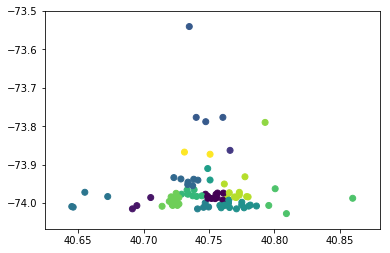

In [9]:
c, l = plotKMeans(lat[1000:1100], lon[10000:10090], 20, 20)

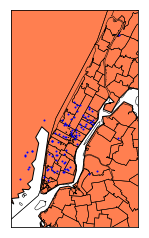

In [109]:
# setup mercator basemap.
lat = data['Lat'].tolist()
lon = data['Lon'].tolist()
man_coords = [40.6664, 40.8851, -74.0587, -73.8890]
shapefiles ={}
shapefiles['shapes/ZIP_CODE_N'] = 'zipcodes'
m1=draw_basemap(lat[1:100], lon[1:100], man_coords, shapefiles) # plots raw points

In [254]:

test_small = createDiGraphK(data, 2000, 2)

In [280]:
def get_pos(G, m):
    pos = {}
    #lat = {k:mean(v) for (k,v) in nx.get_node_attributes(test1, 'lat').items()}
    #lon = {k:mean(v) for (k,v) in nx.get_node_attributes(test1, 'lon').items()}
    lt = nx.get_node_attributes(G, 'lat')
    ln = nx.get_node_attributes(G, 'lon')
    for node_num in list(G.nodes()):
        pos[node_num] = m(ln[node_num], lt[node_num]) # KEEP IN MIND THIS IS NOW X,Y
    return pos

In [341]:
def draw_graph(G, coords=[40.58, 40.88, -74.28, -73.840], shapefiles={}, node_size=50): 
    plt.figure(figsize=(18,12))
    m = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='lightgreen',lake_color='aqua')
    #m = Basemap(projection='merc', width=10, height=10, lat_0=40.783058, lon_0=-73.971252)
    pos = get_pos(G, m)
    print("FINISHED PROJ. COORDINATES...STARTING NODES")
    nx.draw_networkx_nodes(G = G, pos = pos, node_color = 'b', alpha=0.8,node_size=node_size)
    nx.draw_networkx_edges(G = G, pos = pos, edge_color='white', alpha=0.8, arrows = True)
    for file, name in shapefiles.items():
        m.readshapefile(file, name)
    plt.show()
    return m

In [343]:
shapefiles ={}
shapefiles['shapes/ZIP_CODE_N'] = 'zipcodes'
man_coords = [40.58, 40.88, -74.28, -73.840] #manhattan by default

In [309]:
test_all = createDiGraphK(data, len(data), k=30, iters=30)

FINISHED PROJ. COORDINATES...STARTING NODES


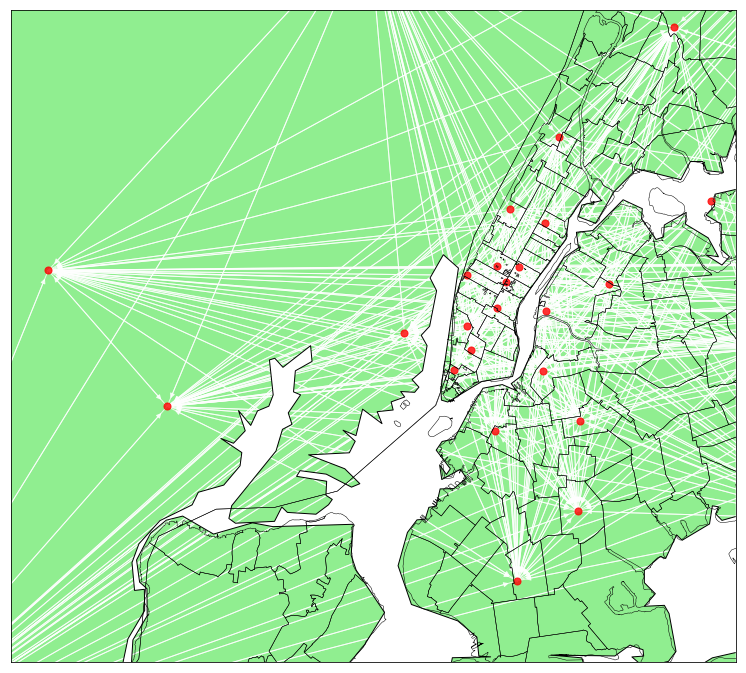

In [311]:
draw_graph(test_all, man_coords, shapefiles)

In [323]:
# scale graph 
node_lt = nx.get_node_attributes(test_all, 'lat').values()
node_ln = nx.get_node_attributes(test_all, 'lon').values()
pad = 0.01
c2 = [min(node_lt)-pad, max(node_lt)+pad, min(node_ln)-pad, max(node_ln)+pad]

FINISHED PROJ. COORDINATES...STARTING NODES


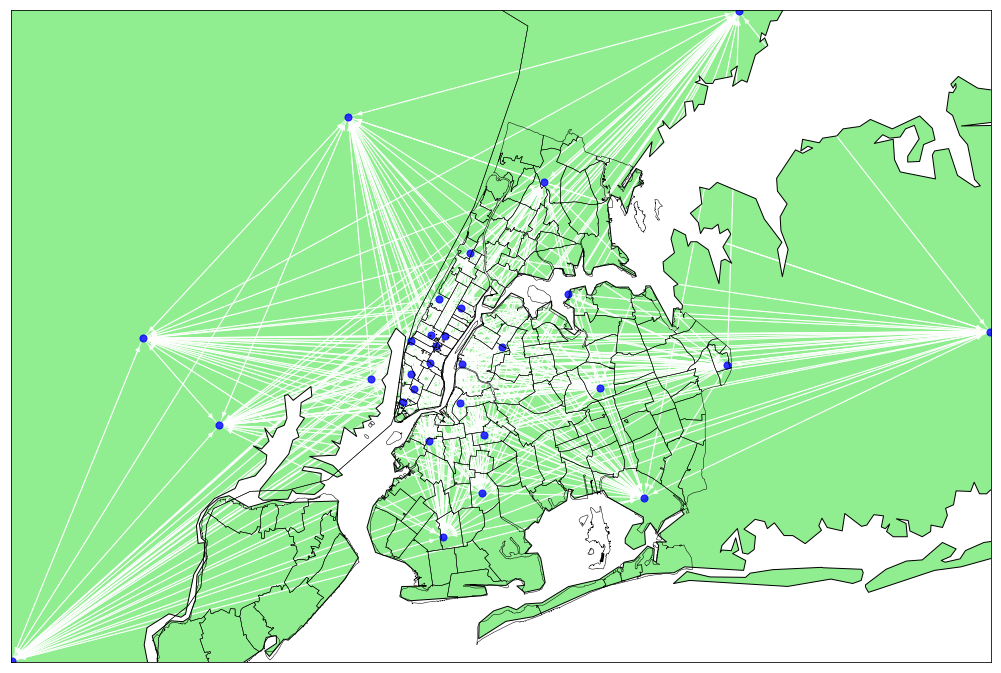

In [324]:
m3 = draw_graph(test_all, c2, shapefiles)

yay we got it visualized! now let's try to make the graph more meaningful by incorporating some of measures of centrality

In [333]:
def get_stats(G):
    stats = {};  
    stats['out_degrees'] = G.out_degree(weight='weight'); 
    stats['closeness_centrality'] = nx.closeness_centrality(G); # hard to do the rest of these because of uniform dist. 
    stats['betweenness_centrality'] = nx.betweenness_centrality(G); 
    stats['eigenvalue_centrality'] = nx.eigenvector_centrality(G); 
    stats['pagerank'] = nx.pagerank(G); 
    return stats

In [355]:
test_all.out_degree(weight='weight')

OutDegreeView({0: 35788, 1: 7877, 2: 815, 3: 16405, 4: 470, 5: 2616, 6: 76973, 7: 4255, 8: 7296, 9: 53172, 10: 191, 11: 11952, 12: 52686, 13: 152, 14: 3511, 15: 3989, 16: 37426, 17: 48205, 18: 51286, 19: 40369, 20: 6112, 21: 3100, 22: 4780, 23: 36379, 24: 440, 25: 18730, 26: 24593, 27: 675, 28: 11944, 29: 2329})

FINISHED PROJ. COORDINATES...STARTING NODES


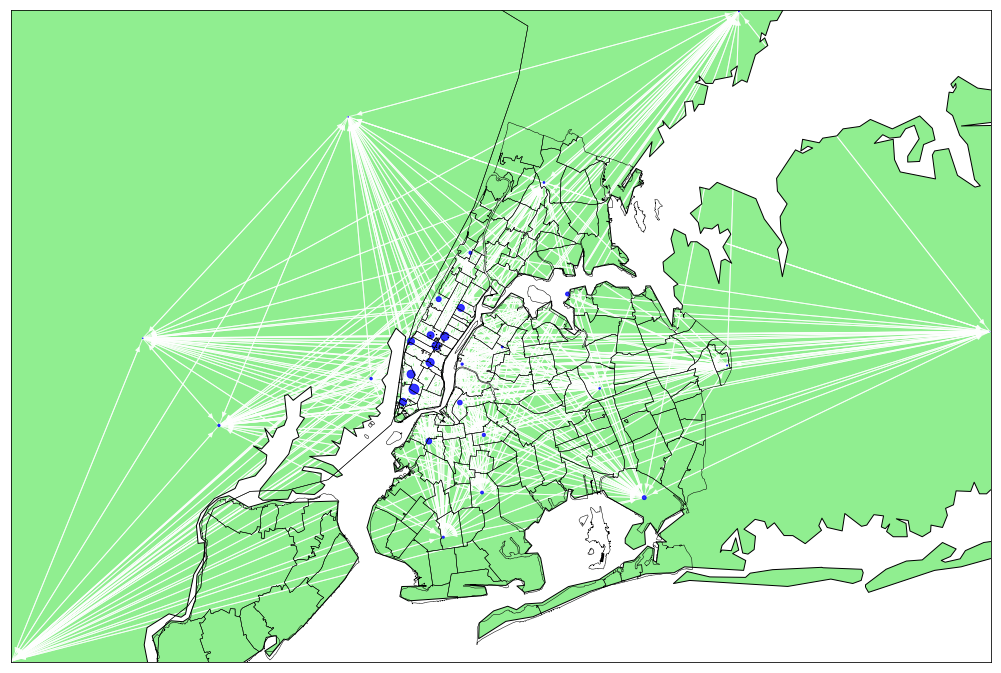

In [348]:
# adjust sizing of nodes based on their relative out-degrees
og_size =  400
sizes = []
for node in list(test_all.nodes()):
    sizes.append(og_size*0.5*(out_weights[node])/2.0)
draw_graph(test_all, c2, shapefiles, node_size=sizes)

In [356]:
def get_weighted_nodes(G, og_size=400):
    # get weights into the range [0.5-1]
    out_raw = G.out_degree(weight='weight')
    out_raw = dict(s['out_degrees'])
    min_out = min(out_raw.values())
    max_out = max(out_raw.values())
    out_weights = {k:(v-min_out)/(max_out-min_out) for (k,v) in out_raw.items()}
    
    # adjust sizing of nodes based on their relative out-degrees
    sizes = []
    for node in list(test_all.nodes()):
        sizes.append(og_size*0.5*(out_weights[node])/2.0)
    return sizes

Hmmm so there's BARELY any usage of the outer nodes. let's try to remove some outliers...and add a function to scale the map if necessary

In [349]:
# remove outliers 
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    for y in a.tolist():
        if y >= quartileSet[0] and y <= quartileSet[1]:
            resultList.append(y)
    return resultList

In [350]:
def createDiGraphK_clean(data, sample_size, k=20, iters=20):
    # cluster data using k-means
    lat = removeOutliers(data['Lat'],1)
    lon = removeOutliers(data['Lon'],1)
    coordinates= np.array(list(zip(lat, lon)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters) 
    # create graph with k nodes
    G = nx.DiGraph(); 
    for pick_up in range(sample_size):
        
        # get k-means centroid from src and randomize dest based on uniform distribution among all clusters
        rand_idx = random.randint(0, len(labels) - 1)
        la = lat[rand_idx]
        lo = lon[rand_idx]
        src = labels[rand_idx]
        dest = random.randint(0, k - 1)
        if (dest == src and src != 0):
            dest = 0

        # increase edge weight from src -->  dest by 1 
        if not G.has_node(src):
            G.add_node(src, lat=0, lon=0)
        if not G.has_node(dest):
            G.add_node(dest, lat=0, lon=0)
        if not G.has_edge(src, dest):
            G.add_edge(src, dest, weight=0)
        G[src][dest]['weight'] += 1
        G.node[src]['lat'] = (G.node[src]['lat'] +  la) / 2 #keep a running average
        G.node[src]['lon'] =  (G.node[src]['lon'] +  lo) / 2
        
        #print("Adding edge from " + str(src) + " to " + str(dest))
        if (pick_up > 1000 and pick_up % 1000 == 0):
            nx.write_graphml(G, "graphs/ktemp.graphml")
    return G 

In [352]:
def get_coords(G, pad=0.01):
    # scale graph 
    node_lt = nx.get_node_attributes(G, 'lat').values()
    node_ln = nx.get_node_attributes(G, 'lon').values()
    c2 = [min(node_lt)-pad, max(node_lt)+pad, min(node_ln)-pad, max(node_ln)+pad]
    return c2

In [362]:
def draw_graph_clean(G, coords=None, shapefiles={}, node_size=600): 
    plt.figure(figsize=(18,12))
    if coords is None:
        coords = get_coords(G)
    m = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='lightgreen',lake_color='aqua')
    #m = Basemap(projection='merc', width=10, height=10, lat_0=40.783058, lon_0=-73.971252)
    pos = get_pos(G, m)
    print("FINISHED PROJ. COORDINATES...STARTING NODES")
    nx.draw_networkx_nodes(G = G, pos = pos, node_color = 'b', alpha=0.8,node_size=get_weighted_nodes(G, node_size))
    nx.draw_networkx_edges(G = G, pos = pos, edge_color='white', alpha=0.8, arrows = True)
    for file, name in shapefiles.items():
        m.readshapefile(file, name)
    plt.show()
    return m

In [365]:
g2 = createDiGraphK_clean(data, len(data), k=50, iters=40)

FINISHED PROJ. COORDINATES...STARTING NODES


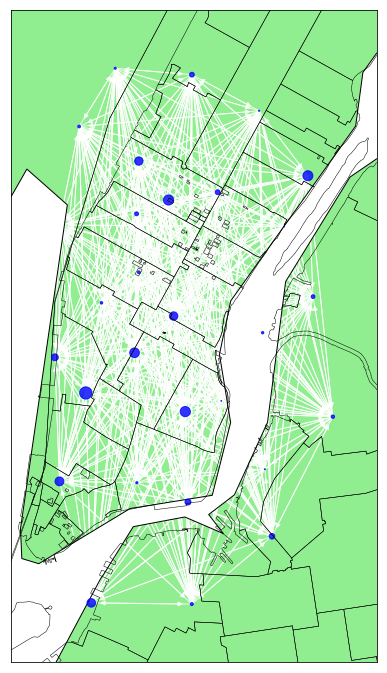

In [363]:
m2 = draw_graph_clean(g2, shapefiles=shapefiles)

ok lit. but what do these places actually mean? I wish we had more k-clusters...we could try finding the optimal k value that would minimize the "sum of squared distances"...but is that what we actually want? 

FINISHED PROJ. COORDINATES...STARTING NODES


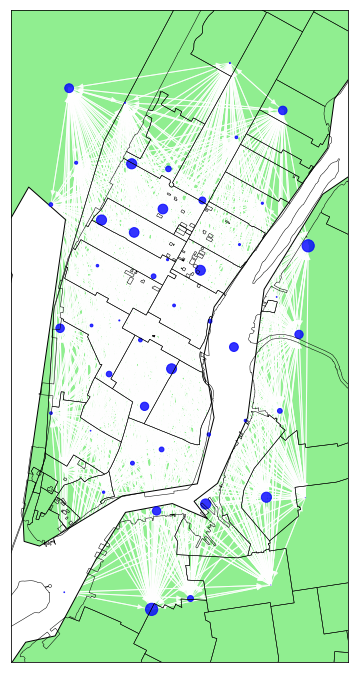

In [366]:
m2 = draw_graph_clean(g2, shapefiles=shapefiles)

In [ ]:
okay so trying to increase kvalues gives us more nodes to consider...bu